In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Table of content with links to the different sections
- [1. Introduction](#1.-Introduction)
- [2. Data](#2.-Data)

# Transform the data in the txt file into a dataframe <a class="anchor" id="2.-Data"></a>

In [78]:
# Read the file into a list of lines
with open('wiki-RfA.txt', 'r') as file:
    lines = file.readlines()

# Create a list of dictionaries, where each dictionary represents a record
df = []
current_entry = {}

# Iterate through each line, current_entry = one log entry with all columns, df = list of all votee/voter pairs
for line in lines:
    line = line.strip()
    if line:
        key, value = line.split(':', 1)
        current_entry[key] = value
    else:
        df.append(current_entry)
        current_entry = {}

# Append  last record
if current_entry:
    df.append(current_entry)

# Convert into DataFrame and store in csv
df = pd.DataFrame(df)
df.columns = ['Source', 'Target', 'Vote', 'Results', 'Year', 'Date', 'Comment']
df


,Source,Target,Vote,Results,Year,Date,Comment
0,Steel1943,BDD,1,1,2013,"23:13, 19 April 2013",'''Support''' as co-nom.
1,Cuchullain,BDD,1,1,2013,"01:04, 20 April 2013",'''Support''' as nominator.--
2,INeverCry,BDD,1,1,2013,"23:43, 19 April 2013",'''Support''' per noms.
3,Cncmaster,BDD,1,1,2013,"00:11, 20 April 2013",'''Support''' per noms. BDD is a strong contri...
4,Miniapolis,BDD,1,1,2013,"00:56, 20 April 2013","'''Support''', with great pleasure. I work wit..."
...,...,...,...,...,...,...,...
198270,172,Vancouverguy,1,1,2003,"02:51, 2 Sep 2003",Support
198271,Angela,WhisperToMe,1,1,2003,"23:45, 26 Nov 2003",Support.
198272,Jiang,WhisperToMe,1,1,2003,,Support. --
198273,Pakaran,WhisperToMe,1,1,2003,"05:38, 5 Dec 2003",Support. Age has nothing to do with maturity....


# Handle inconsistent data

In [79]:
# Set Nan values
# replace field that's entirely space (or empty) with NaN (the case for some Source, Date and Comment)
df.replace(r'^\s*$', np.nan, regex=True, inplace=True)

#handle NaN values in Comment for vectorization
df.Comment = df.Comment.replace(np.nan, None)

# replace inconsistent date
df['Date'] = df['Date'].str.replace('Julu ', 'July ')
df['Date'] = df['Date'].str.replace('Janry ', 'January ')
df['Date'] = df['Date'].str.replace('Mya ', 'May ')
df['Date'] = df['Date'].str.replace('Jan ', 'January ')
df['Date'] = df['Date'].str.replace('Feb ', 'February ')
df['Date'] = df['Date'].str.replace('Mar ', 'March ')
df['Date'] = df['Date'].str.replace('Apr ', 'April ')
df['Date'] = df['Date'].str.replace('Jun ', 'June ')
df['Date'] = df['Date'].str.replace('Jul ', 'July ')
df['Date'] = df['Date'].str.replace('Aug ', 'August ')
df['Date'] = df['Date'].str.replace('Sep ', 'September ')
df['Date'] = df['Date'].str.replace('Oct ', 'October ')
df['Date'] = df['Date'].str.replace('Nov ', 'November ')
df['Date'] = df['Date'].str.replace('Dec ', 'December ')

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%H:%M, %d %B %Y', errors='coerce')

df

,Source,Target,Vote,Results,Year,Date,Comment
0,Steel1943,BDD,1,1,2013,2013-04-19 23:13:00,'''Support''' as co-nom.
1,Cuchullain,BDD,1,1,2013,2013-04-20 01:04:00,'''Support''' as nominator.--
2,INeverCry,BDD,1,1,2013,2013-04-19 23:43:00,'''Support''' per noms.
3,Cncmaster,BDD,1,1,2013,2013-04-20 00:11:00,'''Support''' per noms. BDD is a strong contri...
4,Miniapolis,BDD,1,1,2013,2013-04-20 00:56:00,"'''Support''', with great pleasure. I work wit..."
...,...,...,...,...,...,...,...
198270,172,Vancouverguy,1,1,2003,2003-09-02 02:51:00,Support
198271,Angela,WhisperToMe,1,1,2003,2003-11-26 23:45:00,Support.
198272,Jiang,WhisperToMe,1,1,2003,NaT,Support. --
198273,Pakaran,WhisperToMe,1,1,2003,2003-12-05 05:38:00,Support. Age has nothing to do with maturity....


### Check for missing values and remove them if necessary

In [80]:
# Compute the number and percentage of missing values in each column.
missing_values_stats = pd.DataFrame({'Count': df.isnull().sum(), 'Percentage': df.isnull().sum()/len(df)*100})
# Add a row to indicate the amount of missing values in Source and Date or Comment combined
missing_values_stats.loc['Date not missing & Source missing'] = [df[df['Source'].isnull()].Date.notnull().sum(), df[df['Source'].isnull()].Date.notnull().sum()/len(df['Source'].isnull())*100]
missing_values_stats.loc['Comment not missing & Source missing'] = [df[df['Source'].isnull()].Comment.notnull().sum(), df[df['Source'].isnull()].Comment.notnull().sum()/len(df['Source'].isnull())*100]

missing_values_stats

,Count,Percentage
Source,1661.0,0.837725
Target,0.0,0.000000
Vote,0.0,0.000000
Results,0.0,0.000000
Year,0.0,0.000000
Date,9368.0,4.724751
Comment,7190.0,3.626277
Date not missing & Source missing,0.0,0.000000
Comment not missing & Source missing,0.0,0.000000


We have some missing values in the Source, Date, and Comments columns. In the Comment and Date columns, the amount of missing values is in the order of 4-5% which is quite significant and as they impact only part of the following analysis, we will deal with them later. In the Source column, the amount of missing values is less than 1%, moreover we can see (in the last 2 rows of the dataframe above) that missing values in the Source column are always associated with missing values in the Date and Comments columns therefore we decided to remove the rows with missing values in the Source column.

In [81]:
# Drop rows with missing values in Source column
df.dropna(subset=['Source'], inplace=True)

### Check for duplicates in the data

By going through the data, we saw that there are some duplicates combined with inconsistent data. We will thus handle them before moving on.
In particular, we noticed that some elections are repeated twice in the entries, with each time the same Source, Target, Date and Comment values, but different Year and/or Results values.

Firstly and as the duplicates are aggregated in specific elections (i.e. they have the same Target) we will first select the target with actual duplicates (some of them just don't have any date or comment but comes from the same source, they actually correspond to vote in different election round). By looking at the data we can see that by fixing a threshold at a minimum of 6 duplicates, we can perfectly select the targets with actual duplicates.

Then, we extract duplicates with different results. To define the correct result we compute the proportion of each vote for each target, given the information we found in the Wikipedia page about the Request for Adminship we define the threshold for a successful vote at 70% of support (Vote = 1). 

After that, we also remove the duplicates with different year and keep the one matching the value in the Date column. 

Finally, we also identified some duplicates with different vote (notably one with the actual vote and one with a neutral vote) and so we remove the incorrect neutral vote. 

In [82]:
# Select target with a significant number of duplicates (by manually checking the data we found that 6 discriminate perfectly between users with actual duplicates and users with only missing data or basic comments)
target_with_duplicates = df[df.duplicated(['Source', 'Target', 'Comment', 'Date'], keep=False)].groupby('Target').size() >= 6
target_with_duplicates = target_with_duplicates[target_with_duplicates].index
duplicates = df[df.Target.isin(target_with_duplicates) & df.duplicated(['Source', 'Target', 'Comment', 'Date'], keep=False)].sort_values(by=['Target', 'Source', 'Date'])
#Remove the data of to_remove from df
df = df.drop(duplicates.index)


# Deal with duplicates that have different results 
perc_vote = (duplicates.groupby(['Target', 'Year']).Vote.value_counts(normalize=True) * 100).unstack(level='Vote')
perc_vote['Result'] = perc_vote.apply(lambda x: '1' if x['1'] >= 70 else '-1', axis=1, result_type='reduce')
# Replace results in duplicates with results in perc_vote
duplicates['Results'] = duplicates.apply(lambda x: perc_vote.loc[(x['Target'], x['Year'])]['Result'], axis=1)


# Deal with duplicates that have different years
correct_year = pd.DataFrame({'Year': duplicates.Date.dt.year, 'Target': duplicates.Target})
# Replace nan values in Year with most common year for each Target (some Dates are missing)
correct_year.Year = correct_year.groupby('Target').Year.transform(lambda x: x.fillna(x.mode()[0]))
# Replace years in duplicates with years in correct_year
duplicates = duplicates.drop(columns='Year').join(correct_year.Year.astype(int).astype(str))

# Drop the duplicate rows 
duplicates.drop_duplicates(keep='first', inplace=True)
# Add the duplicates to df
df = pd.concat([df, duplicates]).sort_index()


# Deal with duplicates that have different Vote
double_vote = df[df.duplicated(['Source', 'Target', 'Comment', 'Date'], keep=False) & df.Date.notnull() & (df.Vote == '0')]
# Drop the double_vote rows
df.drop(double_vote.index, inplace=True)

df.sample(3)

,Source,Target,Vote,Results,Year,Date,Comment
133425,Christopher Parham,Encephalon,1,1,2006,2006-03-20 07:18:00,Absolutely.
76759,KojiDude,It Is Me Here,-1,-1,2008,2008-08-19 01:21:00,'''Oppose''' Because the answer to Q4 shows he...
27057,PhilKnight,Waldir,1,1,2010,2010-05-27 23:07:00,'''Support''' - trustworthy editor. Agree the ...


# Store the dataframe in a csv file

In [83]:
df.to_csv('wiki-RfA.csv')

# Some global statistics and visualisation 

In [84]:
stats = df.describe(include='all')
stats.loc['perc_nan'] = (1 - stats.loc['count'] / len(df)) * 100
stats

,Source,Target,Vote,Results,Year,Date,Comment
count,195647,195647,195647,195647,195647,187998,190146
unique,10416,3491,3,2,11,NaN,163218
top,Siva1979,Everyking,1,1,2006,NaN,'''Support'''
freq,1222,978,143379,122015,44164,NaN,3446
mean,NaN,NaN,NaN,NaN,NaN,2008-01-25 16:26:19.400312576,NaN
min,NaN,NaN,NaN,NaN,NaN,2003-08-16 01:25:00,NaN
25%,NaN,NaN,NaN,NaN,NaN,2006-07-10 12:05:30,NaN
50%,NaN,NaN,NaN,NaN,NaN,2007-09-20 21:24:00,NaN
75%,NaN,NaN,NaN,NaN,NaN,2009-04-10 14:52:00,NaN
max,NaN,NaN,NaN,NaN,NaN,2013-06-05 19:50:00,NaN


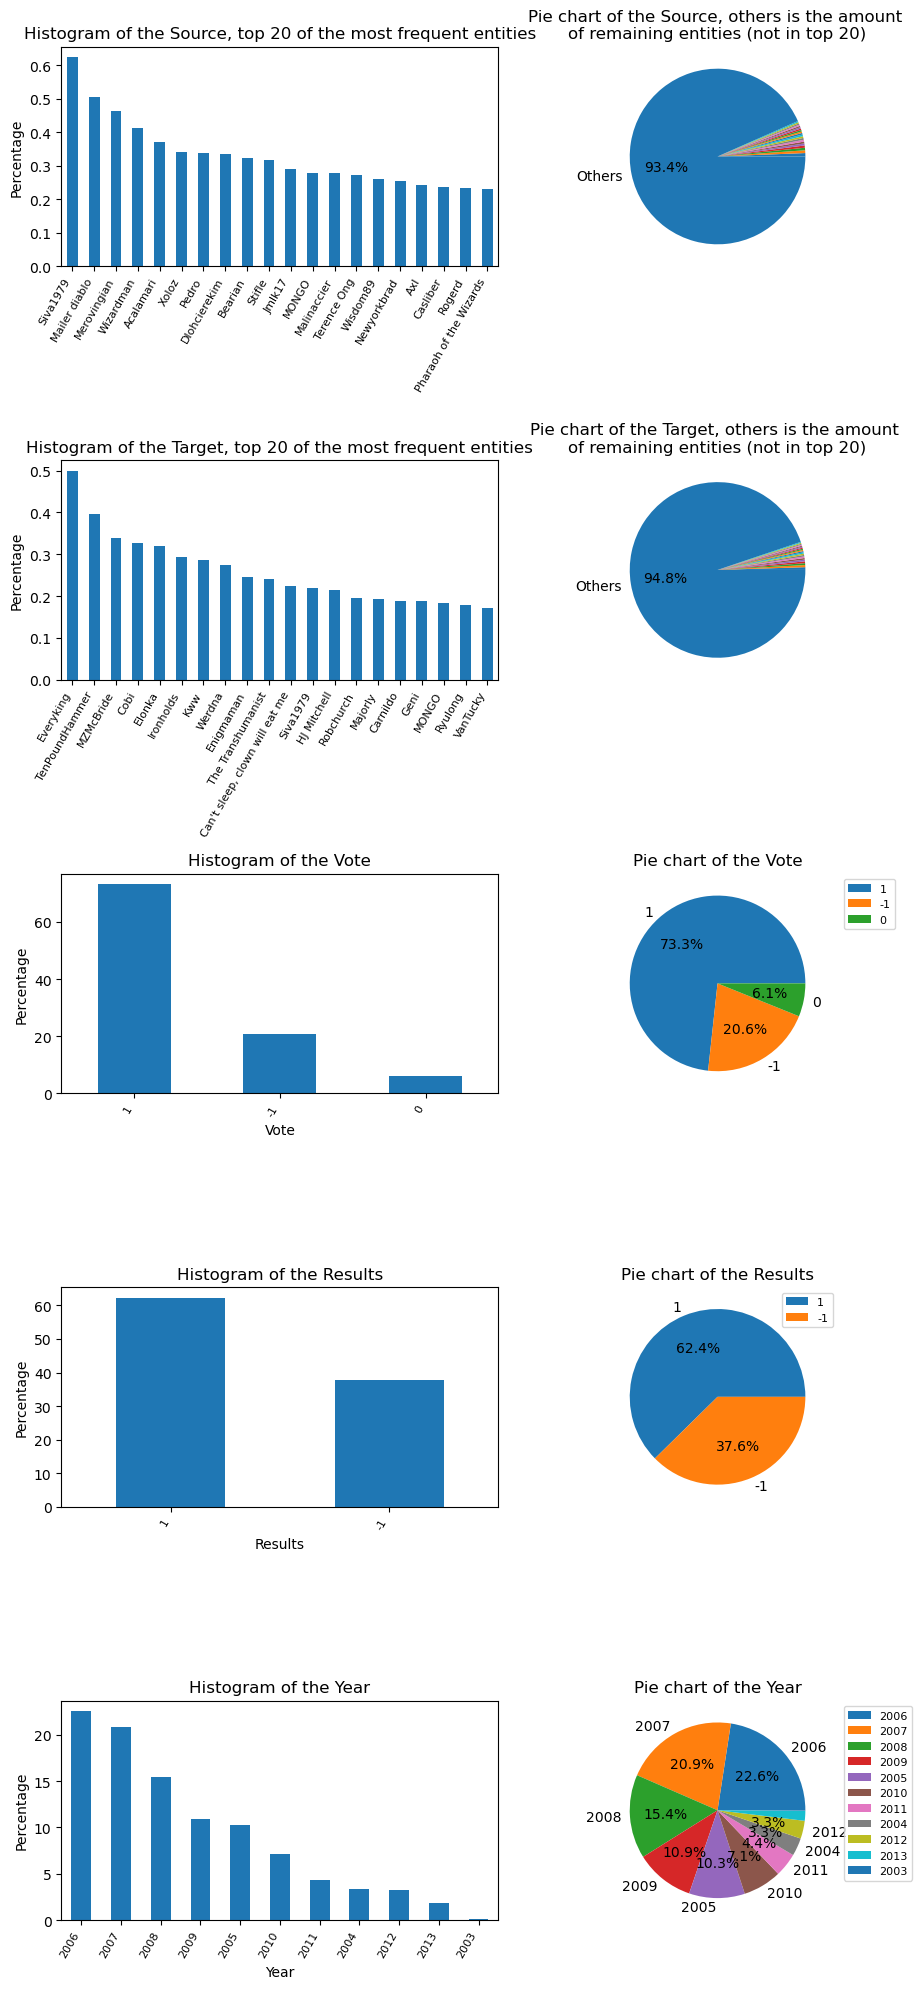

In [85]:
warnings.filterwarnings('ignore')
categorical_cols = ['Source', 'Target']
value_cols = ['Vote', 'Results', 'Year']
all_cols = categorical_cols + value_cols
n_top = 20
fig, axes = plt.subplots(len(all_cols), 2, figsize=(10,4*len(all_cols)))
for i, col in enumerate(all_cols):
    ax1 = axes[(2*i) // 2, (2*i) % 2]
    ax2 = axes[(2*i+1) // 2, (2*i+1) % 2]
    data = df[~df[col].isna()]
    if col in categorical_cols:
        top_n = pd.Series(data[col].value_counts().iloc[:n_top])
        others = pd.Series(data[col].value_counts().iloc[n_top:].sum(), index=['Others'])
        value_counts = pd.concat([top_n, others])
        title_extension_hist = ', top ' + str(n_top) + ' of the most frequent entities'
        title_extension_pie = ', others is the amount \nof remaining entities (not in top ' + str(n_top) + ')'
        
    elif col in value_cols:
        value_counts = data[col].value_counts()
        title_extension_hist = ''
        title_extension_pie = ''
    
    value_counts = 100*value_counts/np.sum(value_counts)
    labels = value_counts.index.to_list()

    # Count plot
    chart = value_counts[value_counts.index != 'Others'].plot(kind='bar', ax=ax1) 
    chart.set_xticklabels(chart.get_xticklabels(), rotation=60, horizontalalignment='right', fontsize = 8)
    ax1.set_title('Histogram of the ' + col + title_extension_hist)
    ax1.set_ylabel('Percentage')
    
    # Pie chart
    wedges, texts, autotexts = ax2.pie(value_counts, labels = labels, autopct='%1.1f%%')
    threshold = 2
    for label, pct_label in zip(texts, autotexts):
        pct_value = pct_label.get_text().rstrip('%')
        if float(pct_value) < threshold:
            label.set_text('')
            pct_label.set_text('')
    
    #if too much labels, don't show legend
    if len(labels) < 12:
        ax2.legend(bbox_to_anchor=(1.05, 1), fontsize = 8)
    ax2.set_title('Pie chart of the ' + col + title_extension_pie)

fig.tight_layout()    
plt.show()